## Large‐scale pricing: accuracy, performance, convergence

In this notebook, we perform large-scale pricing simulations across three numerical methods:
 - Monte Carlo Simulation
 - Finite Difference (PDE: Crank-Nicolson)
 - Binomial Tree Method

Each method is benchmarked against the analytical Black-Scholes price. We compare:
 - Accuracy: Absolute error vs. benchmark
 - Performance: Runtime for increasing resolution
 - Convergence Behavior: How fast methods approach the true price

| Symbol         | Meaning                         | Value / Range           |
|:--------------:|:-------------------------------:|:-----------------------:|
| **S₀**         | Initial spot price              | **100**                 |
| **K**          | Strike price                    | 100                     |
| **r**          | Risk‐free rate                  | 5 %                     |
| **σ**          | Volatility (annual)             | 20 %                    |
| **T**          | Maturity (years)                | 1.0                     |
| **BSM**        | Analytic reference price        | computed below          |
| **Binomial**   | Steps N                          | [10, 50, 100, 200, 500] |
| **Monte Carlo**| Paths N                          | [1 000, 5 000, 10 000, 50 000, 100 000] |
| **PDE**        | Grid N_S = N_t = N               | [20, 40, 80, 160, 320]  |

In [1]:
# --- Setup & Imports ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os, sys

sys.path.append(os.path.abspath("../../"))

from pricing.bsm import bsm_price
from pricing.monte_carlo import mc_european_price
from pricing.pde import crank_nicolson
from pricing.binomial_tree import binomial_crr_price

In [2]:
# Model parameters
S0, K, r, sigma, T = 100, 100, 0.05, 0.20, 1.0
is_call = True

# Resolution settings
binomial_steps = [10, 50, 100, 200, 500]
mc_paths = [1_000, 5_000, 10_000, 50_000, 100_000]
pde_steps = [20, 40, 80, 160, 320]

# Analytic Black–Scholes reference
price_bs = bsm_price(S0, K, r, sigma, T, is_call=is_call)
print(f"BSM reference price = {price_bs:.4f}")

BSM reference price = 10.4506


In [3]:
results = []

# 1) --- Binomial‐CRR ---
for N in binomial_steps:
    t0 = time.time()
    p = binomial_crr_price(S0, K, r, sigma, T, N, is_call)
    t_elapsed = time.time() - t0
    results.append(
        {
            "Method": "Binomial",
            "Resolution": N,
            "Price": p,
            "CI95": 0.0,
            "AbsError": abs(p - price_bs),
            "Runtime": t_elapsed,
        }
    )

# 2) --- Monte Carlo ---
for N in mc_paths:
    t0 = time.time()
    p, ci = mc_european_price(
        S0, K, r, sigma, T, N_paths=N, N_steps=1, is_call=is_call, seed=42
    )
    t_elapsed = time.time() - t0
    results.append(
        {
            "Method": "Monte Carlo",
            "Resolution": N,
            "Price": p,
            "CI95": ci,
            "AbsError": abs(p - price_bs),
            "Runtime": t_elapsed,
        }
    )

# 3) --- Crank–Nicolson PDE ---
for N in pde_steps:
    t0 = time.time()
    p = crank_nicolson(S0, K, r, sigma, T, Smax=4 * K, N_S=N, N_t=N, is_call=is_call)
    t_elapsed = time.time() - t0
    results.append(
        {
            "Method": "PDE",
            "Resolution": N,
            "Price": p,
            "CI95": 0.0,
            "AbsError": abs(p - price_bs),
            "Runtime": t_elapsed,
        }
    )

# assemble into DataFrame
df = pd.DataFrame(results)
df

,Method,Resolution,Price,CI95,AbsError,Runtime
0,Binomial,10,10.253409,0.000000,0.197175,0.000157
1,Binomial,50,10.410692,0.000000,0.039892,0.000434
2,Binomial,100,10.430612,0.000000,0.019972,0.000771
3,Binomial,200,10.440591,0.000000,0.009992,0.001489
4,Binomial,500,10.446585,0.000000,0.003998,0.003898
5,Monte Carlo,1000,10.516569,0.927003,0.065986,0.000294
6,Monte Carlo,5000,10.485018,0.406819,0.034434,0.000327
7,Monte Carlo,10000,10.450170,0.289713,0.000414,0.000378
8,Monte Carlo,50000,10.446164,0.128729,0.004419,0.001630
9,Monte Carlo,100000,10.473892,0.091315,0.023308,0.002982


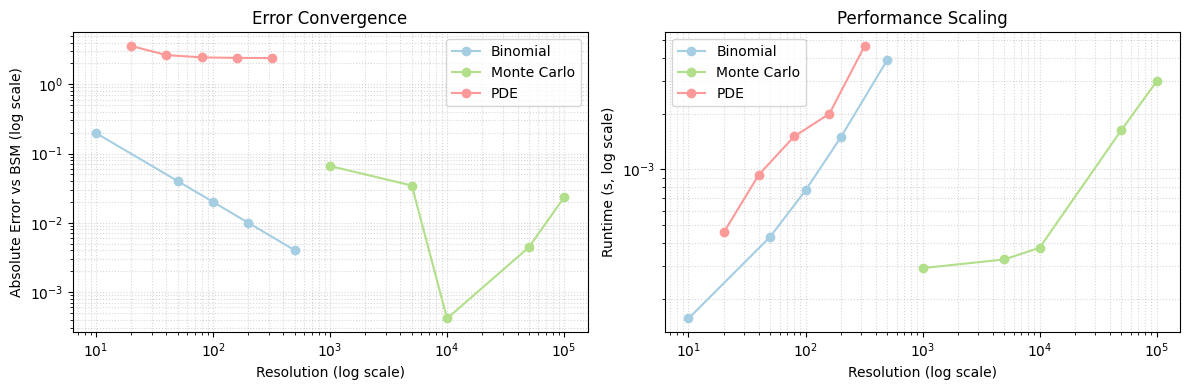

In [4]:
# pastel palette
colors = {"Binomial": "#a6cee3", "Monte Carlo": "#b2df8a", "PDE": "#fb9a99"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# — Error vs Resolution (log–log) —
for method, group in df.groupby("Method"):
    ax1.loglog(
        group["Resolution"],
        group["AbsError"],
        marker="o",
        linestyle="-",
        label=method,
        color=colors[method],
    )

ax1.set_xlabel("Resolution (log scale)")
ax1.set_ylabel("Absolute Error vs BSM (log scale)")
ax1.set_title("Error Convergence")
ax1.grid(which="both", ls=":", alpha=0.5)
ax1.legend()

# — Runtime vs Resolution (log–log) —
for method, group in df.groupby("Method"):
    ax2.loglog(
        group["Resolution"],
        group["Runtime"],
        marker="o",
        linestyle="-",
        label=method,
        color=colors[method],
    )

ax2.set_xlabel("Resolution (log scale)")
ax2.set_ylabel("Runtime (s, log scale)")
ax2.set_title("Performance Scaling")
ax2.grid(which="both", ls=":", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()